# Introduction to Rapids

![Rapids](../nb_images/rapids.png)
<img src="../nb_images/rapids.png" alt="Drawing" style="width: 200px;"/>


Rapids is a data preparation and machine learning library that is designed to take maximum advantage of the Nvidia GPU.  The libraries are called cuDF and cuML and take a lot of the same design and API semantics from Pandas and Sklearn Python libaries.   Speedups of over 10x are not uncommon for a lot of everyday tasks.

If you are familiar with Pandas and Sklearn, this code in this lab will look familiar.  Rapids is still under development, so its not as full featured as the Pandas and Sklearn libraries, but it is continually getting new functions.  

The following lab will walk you through how to use Rapids with a sample dataset.  **This lab will focus on the performance capabilities of Rapids by comparing it to Pandas and Sklearn equivalent operations.** It is not meant to be a machine learning tutorial. 


## A word on performance comparisons of RAPIDS vs Pandas

Pandas and Numpy are two of the most popular libraries for both data engineers and data scientists.  The libraries are very robust and perfomant, but one major drawback is that they are single threaded libraries.  When comparing RAPIDs vs Pandas/Numpy you are seeing the benefit of parallelizing these types of tasks overs potentially thousands of seperate threads.  

## CuDF basics

Built based on the Apache Arrow columnar memory format, cuDF is a GPU DataFrame library for loading, joining, aggregating, filtering, and manipulating data.

cuDF provides a pandas-like API that will be familiar to data engineers & data scientists, so they can use it to easily accelerate their workflows without going into the details of CUDA programming.

Definitions :
* GPU Dataframe : a dataframe from the RAPIDS cuDF library running on the GPU


### Helper functions

Execute the functions below, they are needed for follow-on parts of the lab.  Note the **pgdf** function is a convenience function to display the GPU dataframe in a nice format for jupyter notebook.

In [1]:
# Imports
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import time
import timeit

from datetime import datetime
import math

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import glob
import os
import sys
sys.path.append('../utils/') 

#dask
import dask
from dask import dataframe as dd

# Rapids
import cudf
from cudf.dataframe import DataFrame as RapidsDataFrame

In [2]:
# [print gpu dataframe] helper function to print GPU dataframes 
def pgdf(gdf) :
    display(gdf.to_pandas())

In [3]:
def time_command(cmd,repeat=1) :
    avg_runtime = timeit.timeit(cmd, number=repeat)
    return float(avg_runtime / repeat)

In [4]:
# Dictionary to store results ..
# example "describe" : {"gpu" : []}
# TODO : make display results look better ..
class COMPARE() :
        ## Abstract Custom Implementations
    def __init__(self) :
        #nprint("Loading Data.  Overriding __init__ from dfutils")
        self.tests = []
        self.gpu_results = {}
        self.cpu_results = {}
        self.df_shape = (0,0)
        self.df_memory_gb = 0 

    def add_result(self, test_name, gpu_result, runtime) :
        if test_name not in self.tests :
            self.tests.append(test_name)
            self.gpu_results[test_name] = []
            self.cpu_results[test_name] = []
        
        if(gpu_result == "gpu") :
            self.gpu_results[test_name].append(runtime)
        else :
            self.cpu_results[test_name].append(runtime)
            
    def display_results(self) :
        print("Dataframe size : {} {} GB".format(self.df_shape, self.df_memory_gb))
        print("{:<20} {:<20} {:<20} {:<20}".format("test", "CPU(s)", "GPU(s)", "GPU Speedup"))
        for i in self.tests :
            cpu_mean = sum(self.cpu_results[i]) / (len(self.cpu_results[i])+0.00001)
            gpu_mean = sum(self.gpu_results[i]) / (len(self.gpu_results[i])+0.00001)
            su = cpu_mean / (gpu_mean + .00001)
            print("{:<20} {:<20.4f} {:<20.4f} {:<20.2f}".format(i, cpu_mean, gpu_mean, su ))

run_times = COMPARE()


In [5]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def pca_scree(pca_explained_variance, label) :
        
    # bin is my x axis variable
    bin = []
    for i in range (len(pca_explained_variance)):
        bin.append(i+1)
    # plot the cummulative variance against the index of PCA
    cum_var = np.cumsum(pca_explained_variance)
    plt.plot(bin, cum_var)
    # plot the 95% threshold, so we can read off count of principal components that matter
    plt.plot(bin, [.95]*n_components, '--')
    plt.plot(bin, [.75]*n_components, '--')
    plt.plot(bin, [.50]*n_components, '--')
    #turn on grid to make graph reading easier
    plt.grid(True)
    #plt.rcParams.update({'font.size': 24})
    plt.suptitle(label + ' PCA Variance Explained')
    plt.xlabel('Number of PCA Components', fontsize=18)
    plt.ylabel('Fraction of Variance \nExplained', fontsize=16)
    # control number of tick marks, 
    plt.xticks([i for i in range(0,n_components)])
    plt.show()


### Useful DataFrame attributes

When you create a GPU dataframe, there are a number of methods available for you to understand the composition.  The detailed list is found in the Rapids [cuDF documentation](https://docs.rapids.ai/api/cudf/0.7/) 

Below we will create a small cuDF dataframe and look at some of its attributes.  A few of these attributes come in handy when debugging 

* dtypes  :  Shows all the columns and associated data types 
* shape   :  Shows the shape (rows / columns) of the dataframe
* columns :  Show the column names in a python list


In [ ]:
# Create a simple GPU dataframe
df = cudf.DataFrame()
df['column1'] = [0, 1, 2, 3, 4]
df['column2'] = [float(i + 10) for i in range(5)]  # insert column
df['column3'] = ["bbb","aaa","ccc","eee","Ddd"]  # insert column

In [ ]:
#Print the dataframe
pgdf(df)

In [ ]:
# Dataframe attributes
print("\nDataframe datatypes\n---------------------")
print(df.dtypes)
print("\nDataframe Shape\n---------------------")
print(df.shape)
print("\nDataframe dimesions\n---------------------")
print(df.ndim)
print("\nDataframe Column names\n---------------------")
print(df.columns)

### Create a cuDF dataframe from Numpy/Pandas array
Rapids cuDF supports the conversion of pandas and numpy arrays to cuDF dataframes.  In the example below we show examples of how you can do this for each type

In [ ]:
# Numpy array to cuDF
# Dataframe Operations : Create random large array
a = np.random.rand(100,100)
df = cudf.DataFrame()
df = df.from_records(a)
#df['random_column1'] = [0, 1, 2, 3, 4]
pgdf(df.head())

In [ ]:
# pdf = pd.DataFrame({'a': [0, 1, 2, 3],'b': [0.1, 0.2, None, 0.3]})
# df = cudf.from_pandas(pdf)
# pgdf(df)

### Dataframe Operations : Slice  Example - grab 10 rows and 10 columns

Sometimes you want to grab slices of dataframes.  Here you can use the **iloc** method to easily slice off different rows/columns from your GPU dataframe.

In [ ]:
pgdf(df.iloc[10:12] )

### Optional Exercise : Create a Random numpy array 1000 x 1000 and then convert to GPU dataframe



## CuML basics

CuML is the a machine learning library implemented on the Nvidia GPU.  This allows you to use many of the most common machine learning algorithms without having to write CUDA code.  The list of algorithms is growing with each release so its worth taking a look at the cuML github repo, but in general you can expect a 10x to 50x performance speedup when using the GPU enabled algorithm.  **Later in this lab we will see examples of PCA and linear regression.**

## Dask

Dask is an extremely useful python library that enables parallel execution of arbitrary python programs allowing you to make maximum use of system resources.  It is typically used for libraries that are written in single threaded implementation like pandas and numpy, but its also very useful for running many a parallel tasks when using Rapids.  We will have a code sample to demonstrate this at the end of the lab.


# Lab Use Case 

**The main goal of this lab is to focus on the performance differences of Rapids(GPU) vs Pandas/Sklearn (CPU) implemenations.**  

To do this we will use the Lending Club publicly available dataset. ![lendingclub](../nb_images/lendingclub.png) This data set is published by lending club and contains information regarding prospective loan applicants.  

**As we go through the lab, we will show the similarity in the syntax/usage of the library using this real world dataset and keep track of the runtimes in a comparison report.**



## Lending Club data and Lab Details

In [ ]:
# DEBUG CODE REMOVE LATER

# a = timeit.timeit('"-".join(str(n) for n in range(100))', number=1)
# run_times.add_result("test", "gpu", a)
# run_times.display_results()
# 
# b = timeit.timeit('"-".join(str(n) for n in range(100))', number=100)
# run_times.add_result("test", "cpu", b)
# a = timeit.timeit('"-".join(str(n) for n in range(100))', number=1)
# run_times.add_result("test", "gpu", a)
# b = timeit.timeit('"-".join(str(n) for n in range(100))', number=100)
# run_times.add_result("test", "cpu", b)
# a = timeit.timeit('"-".join(str(n) for n in range(100))', number=1)
# run_times.add_result("test1", "gpu", a)
# b = timeit.timeit('"-".join(str(n) for n in range(100))', number=100)
# run_times.add_result("test1", "cpu", b)
# 
# run_times.display_results()

# Data Preparation using cuDF

Here we will load in the lending club dataset and perform some basic data preparation steps.  

Each section is composed of the same workflow

- [ ] cpu example
- [ ] gpu example
- [ ] comparison of results
- [ ] logging of runtimes



## Load the Lending Club Data

Here we will load the data twice.  Once into a pandas dataframe **loan_pdf** and once into a rapids dataframe **loan_rdf**.  

In [6]:
# import data
filename = "../dataprep_common/loan_project_df.parquet.gzip"
DATA_DOUBLE_FACTOR=3

# Pandas dataframe
loan_pdf = pd.read_parquet(filename)#  , names=ts_cols,dtype=ts_dtypes,skiprows=1)

# Rapids Dataframe
loan_rdf = cudf.read_parquet(filename)#  , names=ts_cols,dtype=ts_dtypes,skiprows=1)

In [ ]:
# Scale up data to 40 million rows
for i in range(DATA_DOUBLE_FACTOR) :
    loan_pdf = pd.concat([loan_pdf,loan_pdf],axis=0)
    loan_rdf = cudf.concat([loan_rdf,loan_rdf],axis=0)
    loan_rdf = loan_rdf.reset_index().drop("index",axis=1)
    loan_pdf = loan_pdf.reset_index().drop("index",axis=1)
    #pgdf(loan_rdf.head())
    #display(loan_pdf.head())
    

In [ ]:
# Dataframe attributes
print("Rapids")
print("\nDataframe datatypes\n---------------------")
print(loan_rdf.dtypes)
print("\nDataframe Shape (rows,cols)\n---------------------")
print(loan_rdf.shape)
print("\nDataframe dimesions\n---------------------")
print(loan_rdf.ndim)
print("\nDataframe Column names\n---------------------")
print(loan_rdf.columns)

# Dataframe attributes
print("\n\nPandas")
print("\nDataframe datatypes\n---------------------")
print(loan_pdf.dtypes)
print("\nDataframe Shape (rows,cols)\n---------------------")
print(loan_pdf.shape)
print("\nDataframe dimesions\n---------------------")
print(loan_pdf.ndim)
print("\nDataframe Column names\n---------------------")
print(loan_pdf.columns)
print("\nDataframe Memory Usage\n---------------------")
print(loan_pdf.memory_usage(index=True).sum())

run_times.df_shape = loan_pdf.shape
run_times.df_memory_gb = loan_pdf.memory_usage(index=True).sum() /10**9

In [ ]:
pgdf(loan_rdf)

## Descriptive Statistics - Describe Performance comparison

The first comparison we will make is using the describe function.  Describe is useful because it looks at all the descriptive statistics of the dataset.  It calculates **mean/standard deviation/medain statistics** for all the numerical columns.  If you have a large dataframe it can take some time to calculate.  Lets see how Rapids performs  with this dataset.

In [ ]:
# CPU / pandas
loan_pdf.describe()

In [ ]:
# GPU / Rapids
pgdf(loan_rdf.describe())

In [ ]:
# Record results
def describe_gpu():
    loan_rdf.describe()

def describe_cpu():
    loan_pdf.describe()

#display(loan_rdf.describe().to_pandas())

run_times.add_result("describe", "gpu", time_command(describe_gpu))
run_times.add_result("describe", "cpu", time_command(describe_cpu))

run_times.display_results()

## One Hot Encoding (OHE) Performance Comparison

One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

Currently, one hot endcoding for Rapids requires the column that is to be encoded to be an integer or float, not a string.  You will need to create an integer column prior to using this!  You can use the hash_encode method to accomplish this, although you lose a little bit of readability.  In future versions of the software this is fixed.

In [62]:
# CPU / pandas example
ohe_cpu_df = pd.get_dummies(loan_pdf['grade'])

In [71]:
# GPU / Rapids example
# cudf 0.9 cudf.reshape.general.get_dummies(df, prefix=None, prefix_sep='_', dummy_na=False, columns=None, cats={}, sparse=False, drop_first=False, dtype='int8')

# Needed 50 hash values to get uniqueness ... probably a better way, but for now lets move on
# print(ohe_gpu_df.grade.hash_encode(stop=50).value_counts())
# print(ohe_gpu_df.grade.hash_encode(stop=50))
# print(ohe_gpu_df.grade.hash_encode(stop=50))

MAX_VAL=50
loan_rdf['grade_hash'] = loan_rdf['grade'].hash_encode(stop=MAX_VAL)
ohe_gpu_df = loan_rdf.one_hot_encoding(column='grade_hash', prefix='g', cats=[27,45,36,28,48,17,25])


In [72]:
# Compare the results
print("Pandas ...")
display(ohe_cpu_df.head(10))
#pgdf(ohe_gpu_df[ohe_gpu_df['grade']=='A'].head(20))
print("Rapids ...")
ohe_gpu_df = ohe_gpu_df.rename({"g_27": "A","g_45": "B","g_36": "C","g_28": "D","g_48": "E","g_17": "F","g_25": "G"})
pgdf(ohe_gpu_df[['A','B','C','D','E','F','G']].head(10))



Pandas ...


,A,B,C,D,E,F,G
0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0
5,1,0,0,0,0,0,0
6,1,0,0,0,0,0,0
7,0,1,0,0,0,0,0
8,1,0,0,0,0,0,0
9,0,1,0,0,0,0,0


Rapids ...


,A,B,C,D,E,F,G
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [74]:
# Record the results

def ohe_cpu() :
    pd.get_dummies(loan_pdf['grade'])

def ohe_gpu() :
    MAX_VAL=50
    loan_rdf['grade_hash'] = loan_rdf['grade'].hash_encode(stop=MAX_VAL)
    ohe_gpu_df = loan_rdf.one_hot_encoding(column='grade_hash', prefix='g', cats=[27,45,36,28,48,17,25])

run_times.add_result("one_hot_encode", "cpu", time_command(ohe_cpu))
run_times.add_result("one_hot_encode", "gpu", time_command(ohe_gpu))
run_times.display_results()


Dataframe size : (0, 0) 0 GB
test                 CPU(s)               GPU(s)               GPU Speedup         
one_hot_encode       0.1069               0.0468               2.28                


## Filter with Date and Time ops - Performance comparison

Current datetime functionality is limited to filtering data set for specific times.  Datetime doesn't not yet support math operations.

Here we will find loan applicants that have a credit line prior to 2010.

In [ ]:
import datetime as dt

search_date = dt.datetime.strptime('2010-01-01', '%Y-%m-%d')

In [ ]:
# CPU / pandas
query_cpu=loan_pdf.query('earliest_cr_line <= @search_date')


In [ ]:
# GPU / Rapids
query_gpu=loan_rdf.query('earliest_cr_line <= @search_date')


In [ ]:
# compare results
display(query_cpu.head())
pgdf(query_gpu.head())

In [ ]:
# Filter Record results
def filter_cpu():
    loan_pdf.query('earliest_cr_line <= @search_date')
    
def filter_gpu():
    loan_rdf.query('earliest_cr_line <= @search_date')
    
run_times.add_result("filter_dt", "cpu", time_command(filter_cpu,repeat=3))
run_times.add_result("filter_dt", "gpu", time_command(filter_gpu,repeat=3))
run_times.display_results()


## Sort by value

Sorting is a very expensive operation in data preparation so its useful to evaluate the performance of method.  Here we select a column to sort by and then compare the results.

In [ ]:
# CPU / pandas
sort_cpu=loan_pdf.sort_values(by='fico_range_high')

In [ ]:
# GPU / Rapids
sort_gpu=loan_rdf.sort_values(by='fico_range_high')

In [ ]:
# compare results
display(query_cpu.head())
pgdf(query_gpu.head())

In [ ]:
# Sorting Record results
def sort_cpu():
    loan_pdf.sort_values(by='fico_range_high')
    
def sort_gpu():
    loan_rdf.sort_values(by='fico_range_high')
    
run_times.add_result("sorting", "cpu", time_command(sort_cpu))
run_times.add_result("sorting", "gpu", time_command(sort_gpu))
run_times.display_results()


## Histograms and Custom functions

Here we demonstrate how fast Rapids is at creating histogram bins.  We use the loan_amount column with a custom function to create a loan_bins column.  Then we grab the value counts using both Pandas and Rapids to get a rough comparison of the speed of these types of operations.


In [ ]:
# custom function example : creates simple bins for loan_amount histogram
def roundto(num):
    roundto=5000
    a = int(num / roundto)
    return float(a*roundto) 


In [ ]:
# CPU / pandas

loan_pdf['loan_bins'] = loan_pdf.loan_amnt.apply(roundto)
loan_pdf['loan_bins'].value_counts()


In [ ]:
# GPU / rapids
loan_rdf['loan_bins'] = loan_rdf.loan_amnt.applymap(roundto)
print(loan_rdf['loan_bins'].value_counts())



In [ ]:
# Record the results
def hist_cpu() :
    loan_pdf['loan_bins'] = loan_pdf.loan_amnt.apply(roundto)
    loan_pdf['loan_bins'].value_counts()

def hist_gpu() :
    loan_rdf['loan_bins'] = loan_rdf.loan_amnt.applymap(roundto)
    loan_rdf['loan_bins'].value_counts()

run_times.add_result("histogram_ops", "cpu", time_command(hist_cpu,repeat=1))
run_times.add_result("histogram_ops", "gpu", time_command(hist_gpu,repeat=1))
run_times.display_results()


## Groupby 

Here we perform some aggregation on the lending club data set to get some per grade statistics.  For this exercise we will compare the speed of aggregating over Pandas dataframes and Rapids dataframes using the **groupby** function as shown in the [Rapids documentation](https://docs.rapids.ai/api/cudf/stable/) .  Notice how the syntax is exactly the same!

In [ ]:
# CPU / Pandas
# stats by grade
grade_stats_pdf = loan_pdf.groupby('grade', as_index=False).agg({"annual_inc": ["count","mean"], "loan_amnt": ["count","mean"]})

In [ ]:
#GPU / Rapids
# stats by grade
grade_stats_rdf = loan_rdf.groupby('grade', as_index=False).agg({"annual_inc": ["count","mean"], "loan_amnt": ["count","mean"]})

In [ ]:
# Grade summary statistics
display(grade_stats_pdf)
pgdf(grade_stats_rdf)

In [ ]:
# Record the results

def groupby_cpu() :
    loan_pdf.groupby('grade', as_index=False).agg({"annual_inc": ["count","mean"], "loan_amnt": ["count","mean"]})

def groupby_gpu() :
    loan_rdf.groupby('grade', as_index=False).agg({"annual_inc": ["count","mean"], "loan_amnt": ["count","mean"]})

run_times.add_result("groupby_ops", "cpu", time_command(groupby_cpu))
run_times.add_result("groupby_ops", "gpu", time_command(groupby_gpu))
run_times.display_results()

## Join 

Joining two dataframes can be an extremely computationally expensive task.  Here we take the grade summary statistics computed in the groupby experiment above, and join it back with our table using grade as the key.  This is a common practice in machine learning to apply average values per group back to the individual row.  This is a form of [mean encoding](https://towardsdatascience.com/why-you-should-try-mean-encoding-17057262cd0)

In [ ]:
# Pandas Join
loan_join_pdf = loan_pdf.set_index('grade').join(grade_stats_pdf.set_index('grade'),on="grade",how="left").reset_index()

In [ ]:
#cuDF Join
loan_rdf.set_index('grade').join(grade_stats_rdf.set_index('grade'),on="grade",how="left").reset_index()

In [ ]:
# Record the results
def join_cpu() :
    loan_pdf.set_index('grade').join(grade_stats_pdf.set_index('grade'),on="grade",how="left").reset_index()
def join_gpu() :
    loan_rdf.set_index('grade').join(grade_stats_rdf.set_index('grade'),on="grade",how="left").reset_index()

run_times.add_result("join_ops", "cpu", time_command(join_cpu))
run_times.add_result("join_ops", "gpu", time_command(join_gpu))
run_times.display_results()

# Machine Learning

## PCA (cuML and sklearn) - Performance comparison

<img src="https://github.com/dustinvanstee/random-public-files/raw/master/techu-pca.png"  width="200" height="125" align="middle"/>

Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. The number of principal components is less than or equal to the number of original variables.

A simple way to think about PCA is that it helps compress the data in a lossy representation of the original dataset.

**Lets compare the performance of the Sklearn (cpu-based) implemenation vs cuML!**

In [ ]:
# Helper function to normalize GPU dataframe function
def normalize_df(gdf) :
    for col in gdf.columns :
        gdf[col] = (gdf[col] - gdf[col].mean()) / gdf[col].std()
    return gdf

### Prepare the data for PCA
Here we do some initial data preparation to normalize the dataframe columns.  We arent comparing performance of this step, its just to get us ready to do the comparison.

In [ ]:
X_cols = list(loan_rdf.columns)
print("Analysis Continuing with {}".format(X_cols))
X_cols.remove('default')
X_cols.remove('grade')
X_cols.remove('grade_hash')
X_cols = [x for x in X_cols if loan_rdf[x].dtype == "float64" or loan_rdf[x].dtype == "int8"]
print("Analysis Continuing with {}".format(X_cols))
# All types must be same ....
for x in X_cols :
    loan_rdf[x] = loan_rdf[x].astype("float64")

#print(loan_rdf[X_cols].dtypes)
print("Normalizing dataframe prior to PCA")
loan_norm_rdf = normalize_df(loan_rdf[X_cols])


In [ ]:
print("Normalized Dataframe")
print(loan_norm_rdf[X_cols].dtypes)
pgdf(loan_norm_rdf) #.describe()


## Principal Component Analysis (PCA) Performance 

We will compare the runtimes of PCA on CPU and then on GPU and also compare the results to make sure they are the same.  

Here we take the normalized frame we built above and copy to pandas.  The two dataframes we will be working with are 

* loan_norm_pdf : normalized pandas dataframe
* loan_norm_rdf : normalized GPU/RAPIDS dataframe

these are exactly the same dataframe ...

In [ ]:
# PCA
# Both import methods supported
from cuml import PCA
from cuml.decomposition import PCA as PCA_gpu
from sklearn.decomposition import PCA as PCA_cpu
n_components=5
loan_norm_pdf = loan_norm_rdf.to_pandas()


In [ ]:
# RUN PCA ! : CPU / Sklearn implementation
pca_loan_cpu = PCA_cpu(n_components=n_components)
pca_loan_cpu.fit(loan_norm_pdf)


In [ ]:
# RUN PCA ! : GPU / cuML implementation
pca_loan_gpu = PCA_gpu(n_components=n_components)
pca_loan_gpu.fit(loan_norm_rdf)


**Compare results** : For PCA we use a scree plot to compare the results.  Scree plots show how much variance in the dataset is explained by each additional principal component.  Below, run the cell and just eyeball the graphs and convince yourself they are the same
    

In [ ]:
# Compare results ...

display(pca_scree(pca_loan_cpu.explained_variance_ratio_, "CPU"))
pca_scree(pca_loan_gpu.explained_variance_ratio_, "GPU")

In [ ]:
# record PCA performance results
def pca_cpu() :    
    print("cpu pca")
    pca_loan_cpu = PCA_cpu(n_components=n_components)
    pca_loan_cpu.fit(loan_norm_pdf)


def pca_gpu() :
    pca_loan_gpu = PCA_gpu(n_components=n_components)
    pca_loan_gpu.fit(loan_norm_rdf)

    
#print(loan_norm_rdf.shape)    
run_times.add_result("pca", "gpu", time_command(pca_gpu, repeat=2))
run_times.add_result("pca", "cpu", time_command(pca_cpu, repeat=2))

run_times.display_results()

## Linear Regression (cuML / sklearn // snapML)

Linear regression is one of the most common algorithms applied to structured data.  Its useful when trying to make a prediction of a continuous variable.  For example, you could use linear regression to try and predict the total expected payment of a loan given historical data about default rates.  Lets try this below with our data set.  (Note lending club doesn't explicity provide this data in its data set, so we will use a fictitious total_payment column in our analysis)

In [ ]:
# Linear Regression : CPU / Sklearn
from sklearn.linear_model import LinearRegression as LRSKL
X = loan_norm_rdf.to_pandas()
y = loan_rdf['default'].to_pandas()    
lr_cpu = LRSKL(fit_intercept = True, normalize = False)
res_cpu = lr_cpu.fit(X,y)

In [ ]:
# Linear Regression : GPU / Rapids cuML example
from cuml.linear_model import LinearRegression as LRCUML
X = loan_norm_rdf
y2 = loan_rdf['default'].astype("float64")    
lr_gpu = LRCUML(fit_intercept = True, normalize = False) #, algorithm = "eig")
res_gpu = lr_gpu.fit(X,y2)


In [ ]:
# Compare results
print("Coefficients:")
print(res_cpu.coef_)
print("intercept:")
print(res_cpu.intercept_)

print("Coefficients:")
print(res_gpu.coef_)
print("intercept:")
print(res_gpu.intercept_)


In [ ]:
#Record Results 

# CPU 
def lr_cpu() :
    lr_cpu = LRSKL(fit_intercept = True, normalize = False)
    res = lr_cpu.fit(X,y)
    
X = loan_norm_rdf.to_pandas()
y = loan_rdf['default'].to_pandas()    
run_times.add_result("linear_reg", "cpu", time_command(lr_cpu, repeat=5))


# GPU
def lr_gpu() :
    lr_gpu = LRCUML(fit_intercept = True, normalize = False, algorithm = "eig")
    res = lr_gpu.fit(X,y)

X = loan_norm_rdf
y = loan_rdf['default'].astype("float64")    
run_times.add_result("linear_reg", "gpu", time_command(lr_gpu, repeat=5))



run_times.display_results()    



# Other interesting applications

## Dask With RAPIDS

In [ ]:
import os

import numpy as np
import pandas as pd
import cudf
import dask_cudf

np.random.seed(12)

#### Portions of this were borrowed and adapted from the
#### cuDF cheatsheet, existing cuDF documentation,
#### and 10 Minutes to Pandas.

In [ ]:
#from dask_cuda import LocalCUDACluster
from dask.distributed import Client

#cluster = LocalCUDACluster()  # runs on eight local GPUs
client = Client('127.0.0.1:8786')

client

In [ ]:
import dask.array as da
x = da.random.random((10000,10000,10), chunks=(1000,1000,5))
y = da.random.random((10000,10000,10), chunks=(1000,1000,5))
z = (da.arcsin(x) + da.arccos(y)).sum(axis=(1,2))

z.compute()

In [ ]:
z.visualize()

In [ ]:
# import data
#aaa = "../rawdata/example.csv"

#gdf = dask_cudf.read_csv(aaa)  # wrap around many CSV files
#print(gdf.dtypes)
#gdf.head().to_pandas()
#gdf['loan_amnt'].sum()


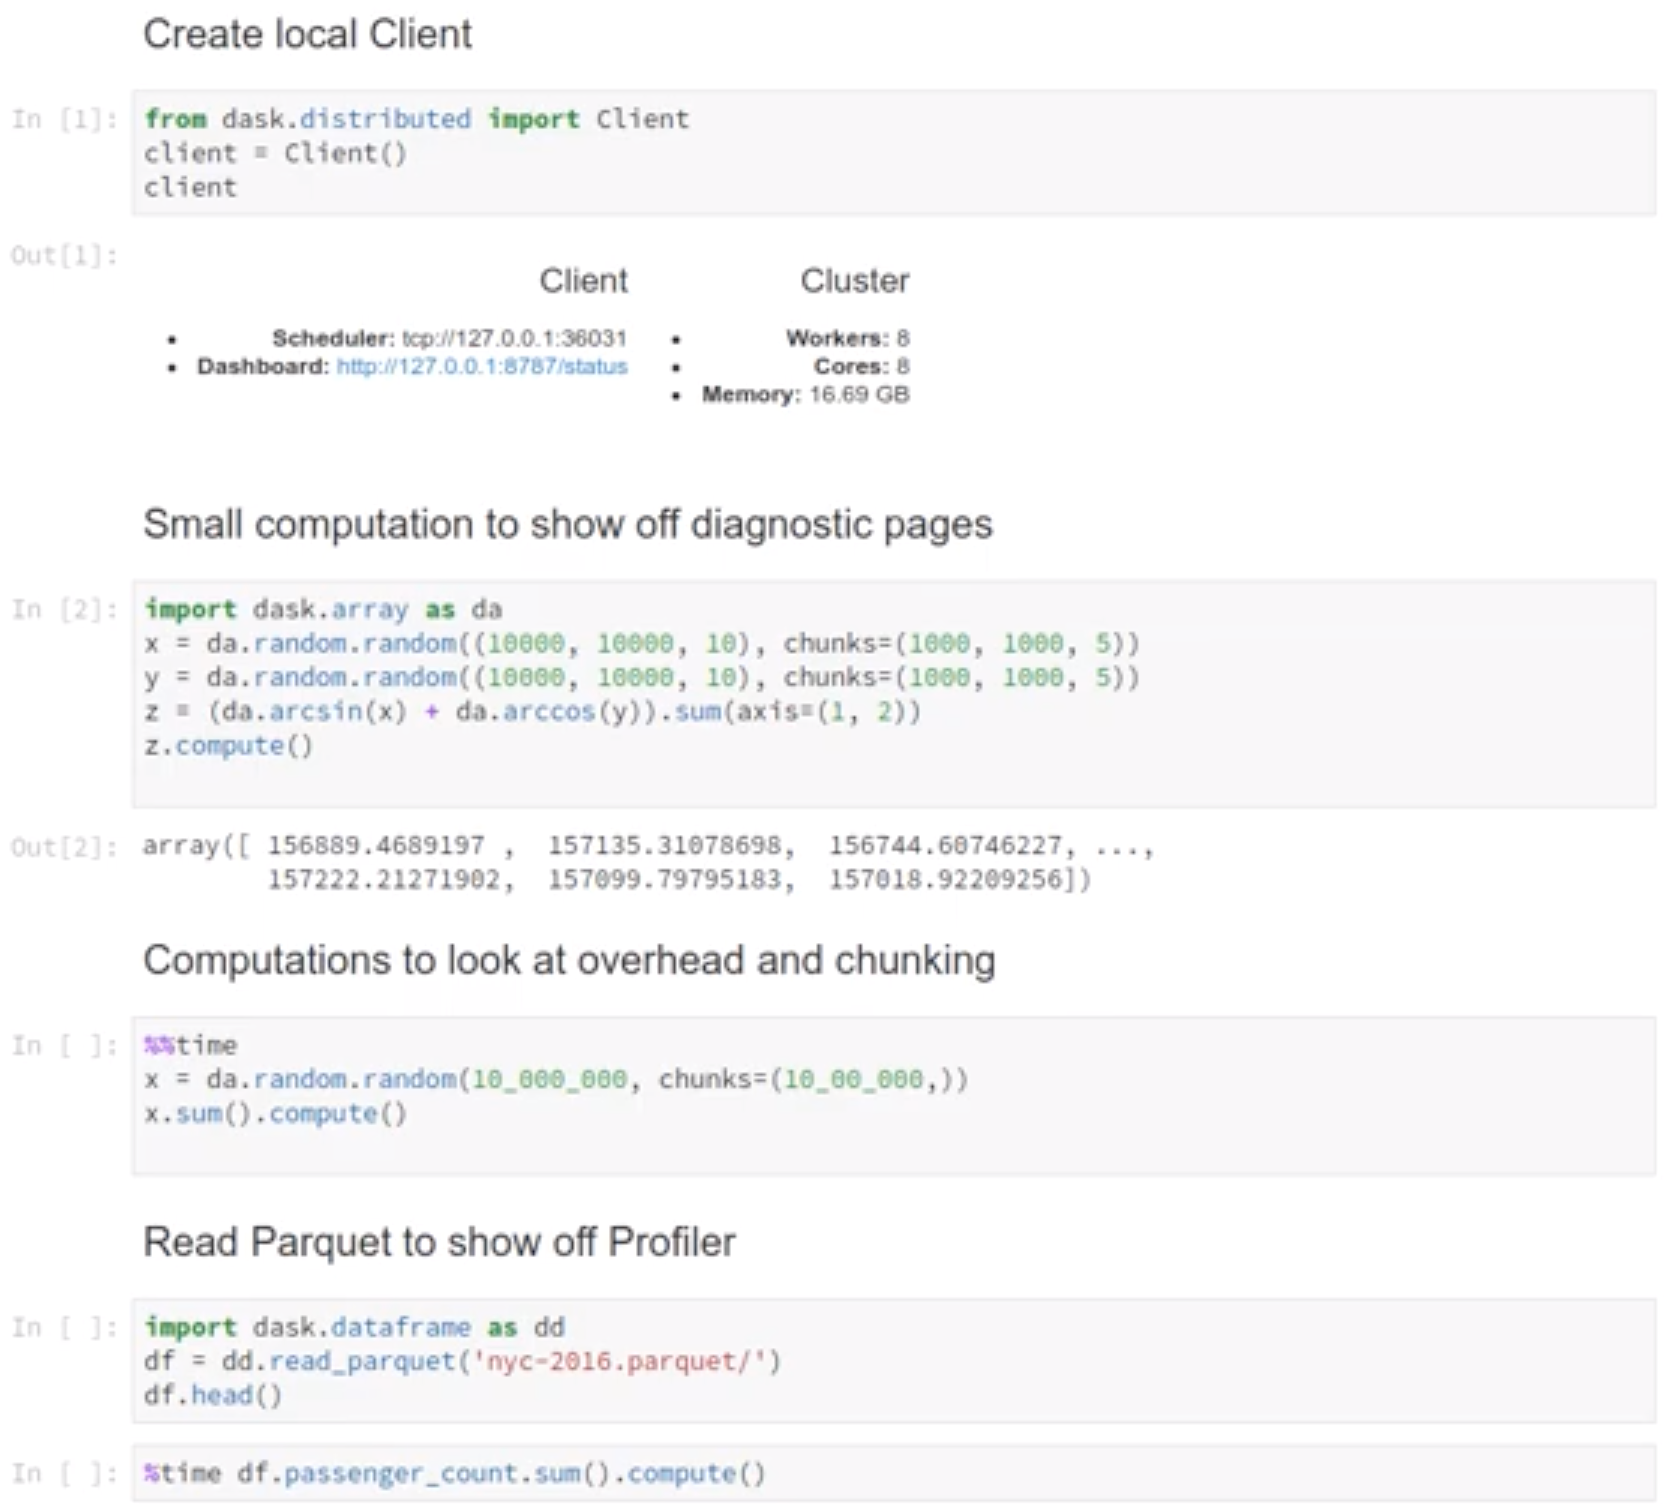

In [ ]:
ddf = dask_cudf.from_cudf(loan_norm_rdf, chunksize=10000)

In [ ]:
ddf

In [ ]:
ddf.loan_amnt.sum()

In [ ]:
ddf.loan_amnt.sum().compute()

## xgboost with Rapids

In [ ]:
from dask.distributed import Client, LocalCluster
import dask.dataframe as dd
import dask.array as da
import numpy as np
import xgboost as xgb
#import GPUtil
import time


# Define the function to be executed on each worker
def train(X, y, available_devices):
    dtrain = xgb.dask.create_worker_dmatrix(X, y)
    local_device = available_devices[xgb.rabit.get_rank()]
    # Specify the GPU algorithm and device for this worker
    params = {"tree_method": "gpu_hist", "gpu_id": local_device}
    print("Worker {} starting training on {} rows".format(xgb.rabit.get_rank(), dtrain.num_row()))
    start = time.time()
    xgb.train(params, dtrain, num_boost_round=500)
    end = time.time()
    print("Worker {} finished training in {:0.2f}s".format(xgb.rabit.get_rank(), end - start))


def main():
    max_devices = 16
    # Check which devices we have locally
    # available_devices = GPUtil.getAvailable(limit=max_devices)
    available_devices = [0,1]
    # Use one worker per device
    cluster = LocalCluster(n_workers=len(available_devices), threads_per_worker=4)
    client = Client(cluster)

    # Set up a relatively large regression problem
    n = 100
    m = 10000000
    partition_size = 100000
    X = da.random.random((m, n), partition_size)
    y = da.random.random(m, partition_size)

    xgb.dask.run(client, train, X, y, available_devices)

main()

## SnapML + Rapids

In [ ]:
### SnapML

X = loan_norm_rdfloan_rdf2.to_pandas()
y = loan_rdf['default'].to_pandas()

from pai4sk.linear_model import Ridge as LRSNAP
clf = LRSNAP(alpha=1.0)
clf.fit(X, y) # doctest: +NORMALIZE_WHITESPACE


#Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
#      normalize=False, random_state=None, solver='auto', tol=0.001)

# Summary

In [ ]:
#from cudf.core import DataFrame, Series



In [ ]:
print(df[["cats","dogs"]])
print(df.describe())

In [ ]:
print(uvals,labels)

## Lessons Learned

lessons learned ... data MUST be clean prior to descibe functions.  Errors encountered 
- duplicate index caused error (this was due to concatenating dataframes)
- NaN causes KeyError messages.  Columns must be clean !
- Pandas takes care of these automatically ....

In [ ]:
# NaN report
def nan_report(df) :
    for c in df.columns :
        print("{} {}".format(c, df[c].null_count))

nan_report(loan_rdf)